<a href="https://colab.research.google.com/github/james-oldfield/PandA/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PandA: Full demo

This notebook demonstrates a number of features of our method for local image editing, including:

- how to apply the decomposition on a number of architectures.
- how to use the learnt parts for local image editing.
- how to refine the learnt global parts factors for a sample of interest.

In [ ]:
import os
os.chdir('/content')
CODE_DIR = 'PandA'
!git clone https://github.com/james-oldfield/PandA.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')
!pip install tensorly==0.7.0 nltk -q

In [1]:
#@title Setup & imports
%load_ext autoreload
%autoreload 2

from PIL import Image
import torch
import tensorly as tl
import numpy as np
tl.set_backend('pytorch')

from utils import plot_masks, plot_colours, mapRange
from networks.genforce.utils.visualizer import postprocess_image as postprocess
from matplotlib import pyplot as plt

# (for biggan)
import nltk
nltk.download('wordnet')

device = torch.device('cuda')

[nltk_data] Downloading package wordnet to /homes/jo001/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## build model

Select an architecture and dataset here. There are *many* more architectures available. See `./networks/genforce/models/model_zoo.py` for all.

**Note**: if you're using `model_name = "biggan"`, you'll need to specify a list of the classes of interest here, such as
```python
model_name = "biggan"
biggan_classes = ['alp', ..., 'lakeside']
```

Building generator for model `stylegan2_afhqcat512` ...
{'gan_type': 'stylegan2', 'resolution': 512}
Finish building generator.
Loading checkpoint
Finish loading checkpoint.
-- Partial Z shape at layer 7: torch.Size([1, 512, 32, 32])


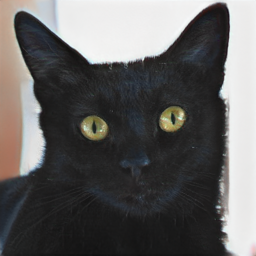

In [2]:
#@title { display-mode: "form", run: "auto" }
from model import Model as Model
model_name = "stylegan2_afhqcat512"  #@param ["stylegan2_afhqcat512","biggan","stylegan2_afhqdog512","stylegan2_ffhq1024","stylegan2_car512","stylegan2_metfaces1024","stylegan2_church256","stylegan_ffhq1024","stylegan_celebahq1024"]

#@markdown Enter comma-separated list of ImageNET classes, or ignore if not using BigGAN:
biggan_classes = 'alp,breakwater' #@param {type:"string"}
biggan_classes = biggan_classes.split(',')

layer = 7 #@param {type:"slider", min:2, max:10, step:1}

M = Model(model_name, trunc_psi=1.0, biggan_classes=biggan_classes, device=device, layer=layer)
display(Image.fromarray(M.image))

## initialisation
 
We first perform initialisation for the appearance factors here:

In [3]:
M.HOSVD()

Starting loops...
Generated 1000 gan samples...
... HOSVD done


## decomposition
 
Now, we can apply the decomposition, with a specified number of parts and appearance factors with the `ranks` list. If one wishes, one can also run this with autograd with PyTorch for comparison, using the `M.decompose_autograd` method (which can be less sensitive to the LR, due to its using Adam, but take ~3x as long).

Here, we solve our constrained optimisation problem with projected gradient descent:

$$
\begin{align}
\min_{\mathbf{A}, \mathbf{P}}
\mathcal{L}(\mathcal{Z},\mathbf{A}, \mathbf{P}) =
\min_{\mathbf{A}, \mathbf{P}}
\sum_{i=1}^N
\lvert\lvert \mathbf{Z}_i -
\mathbf{A}
    \left(
      {\mathbf{A}}^\top
      {\mathbf{Z}_i}
      {\mathbf{P}}
    \right)
{\mathbf{P}}^\top
\rvert\rvert_F^2 \textrm{ s.t. } \mathbf{P} \geq \mathbf{0}.
\end{align}
$$

At every few iterations, we display the learnt parts factors, so one can visualize how they change over the "training" process.

**Note**: as a rule of thumb for manual PGD, decrease the LR by an order of magnitude each time you decompose at one layer deeper.

Uc shape: torch.Size([512, 512]), Us shape: torch.Size([1024, 16])
ITERATION: 0


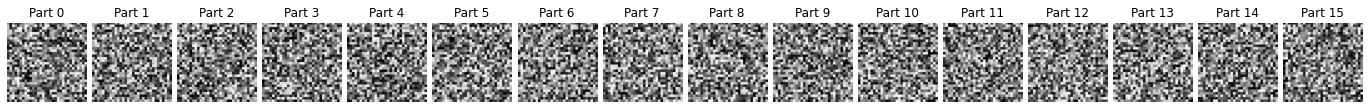

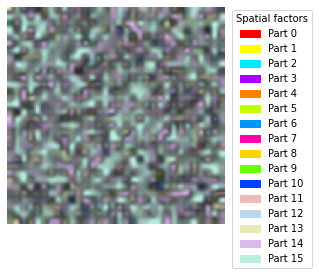

ITERATION: 2000


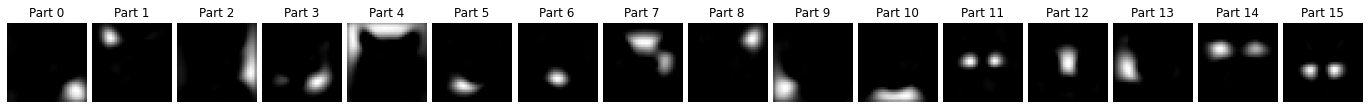

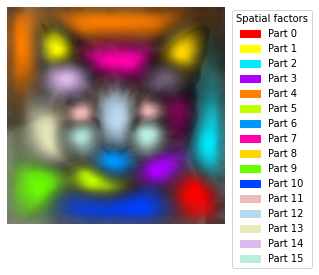

ITERATION: 4000


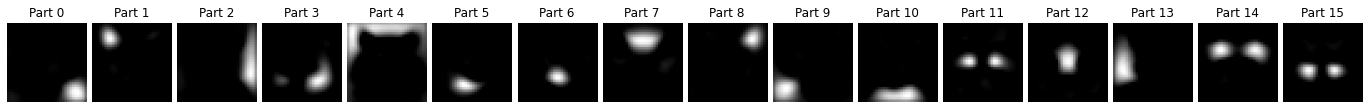

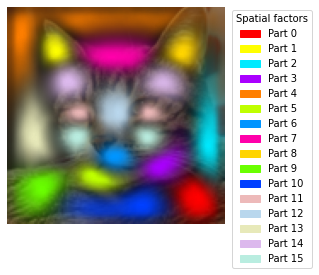

ITERATION: 6000


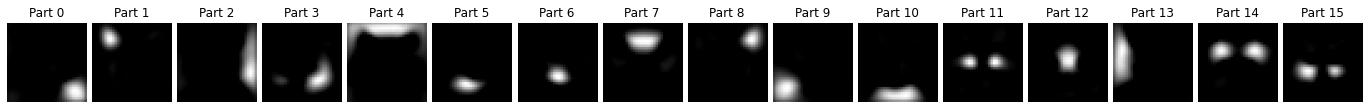

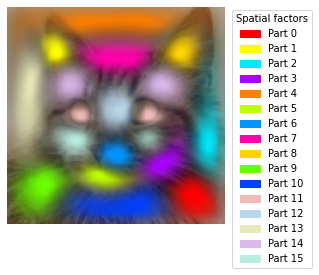

ITERATION: 8000


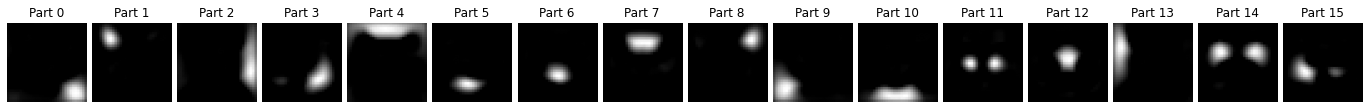

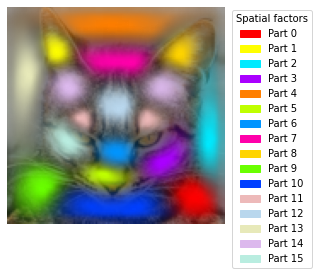

In [4]:
M.decompose(lr=1e-6, ranks=[512, 16], verbose=True, log_modulo=2000, its=10000)
# M.decompose_autograd(lr=1e-3, ranks=[512, 16], verbose=True)

## visualise the learnt global parts

After training, we reshape the parts factor into a square matrix, and can observe the region over which it sits. We can then choose from these parts for local image editing

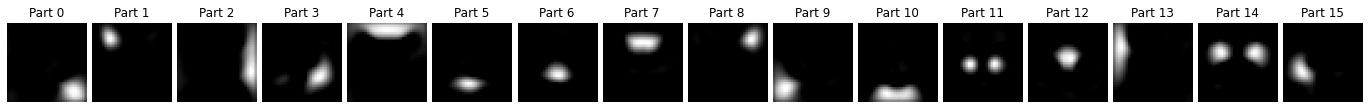

In [5]:
plot_masks(M.Us.T, s=M.s, r=min(M.ranks[1], 32))

# local image editing

- We can now add learnt appearance vectors at the learnt semantic part(s).
- Here, we choose the `5`th appearance vector (with magnitude `lam[0]`, and add it under the `11`th semantic part, to increase the eyes' size.

Technically speaking, this computes the outer product $\alpha\mathbf{a}_j \mathbf{p}_k^\top$, which forms a rank-$1$ matrix that is added to the mode-$3$ unfolding of the target samples' intermediate feature maps. The forward pass then continues with this edited feature maps.

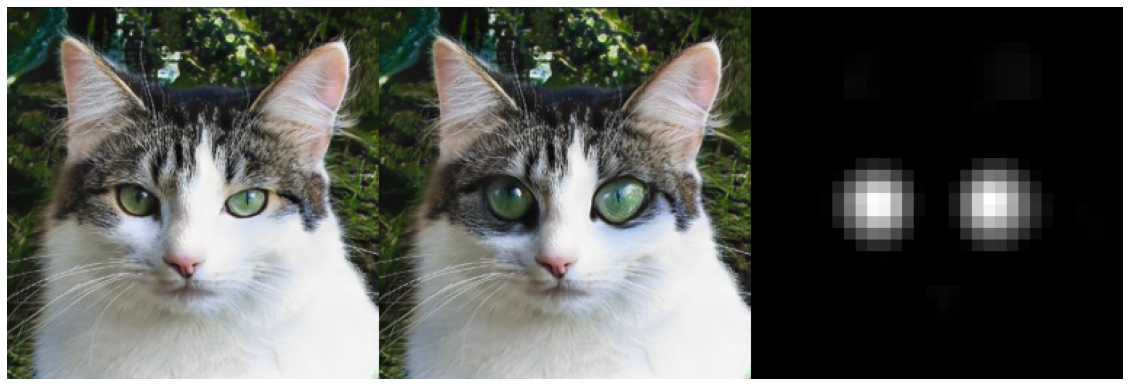

In [6]:
part = [[11]]  # list of target parts here
appearance = [5]
lam = [40]
t = 2

Z, image, image2, part_img = M.edit_at_layer(part, appearance, lam, t, M.Uc, M.Us)

plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(np.concatenate([image, image2, part_img], 1))
plt.show()

---

# Refinement

As we describe in our paper, the alternating algorithm makes the implicit assumption that samples are aligned. In general, AFHQ samples are not aligned particularly well. We select a particular sample `t=19` whose semantic parts (ears) are not found in the same spatial locations.

To address this, we can apply our refinement step. This refinement objective is given in the paper by

$$
\begin{align}
\label{eq:refine}
\min_{\tilde{\mathbf{P}}_i}
\mathcal{L}_R(\mathbf{Z}_i,\mathbf{A}, \tilde{\mathbf{P}}_i) = 
\min_{\tilde{\mathbf{P}}_i}
\lvert\lvert \mathbf{Z}_i -
\mathbf{A}
\left(
  {\mathbf{A}}^\top
  {\mathbf{Z}_i}
  \tilde{\mathbf{P}}_i
\right)
{\tilde{\mathbf{P}}_i}^\top
\rvert\rvert_F^2 \textrm{ s.t. } \tilde{\mathbf{P}}_i \geq \mathbf{0}.
\end{align}
$$

We can perform projected gradient descent to minimize this with:

In [7]:
t = 19
Z, image, image2, part_img = M.edit_at_layer(part, appearance, lam, t, M.Uc, M.Us)

np.random.seed(t)
noise = torch.Tensor(np.random.randn(1, M.generator.z_space_dim)).to(M.device)
Z, image = M.sample(noise, layer=M.layer)

UsR = M.refine(Z, image, lr=1e-5, log_modulo=np.inf, its=100)

## visualizing global vs refined parts factors

Now let's view the global and refined (for this sample) parts factors respectively. We see the refined factors much better capture this particular unaligned sample's parts:

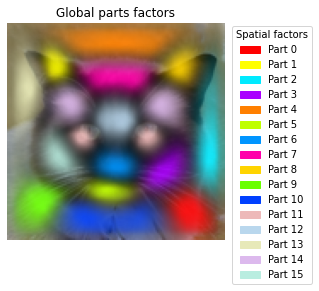

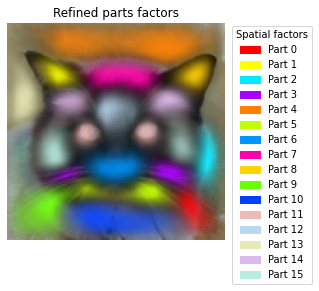

In [8]:
plot_colours(image, M.Us.T, s=M.s, r=M.ranks[-1], seed=-1, alpha=0.9)
plt.title('Global parts factors')
plt.show()

plot_colours(image, UsR.T, s=M.s, r=M.ranks[-1], seed=-1, alpha=0.9)
plt.title('Refined parts factors')
plt.show()

# editing with global vs refined parts factors

We now show the difference between using the global factors and the refined factors to edit sample `t=16`:

(Note that, here, we simultaneously demonstrate the way in which the semantic parts can be combined or edited (if desired), by using both the `1`st and `8`th part together corresponding to one ear each)

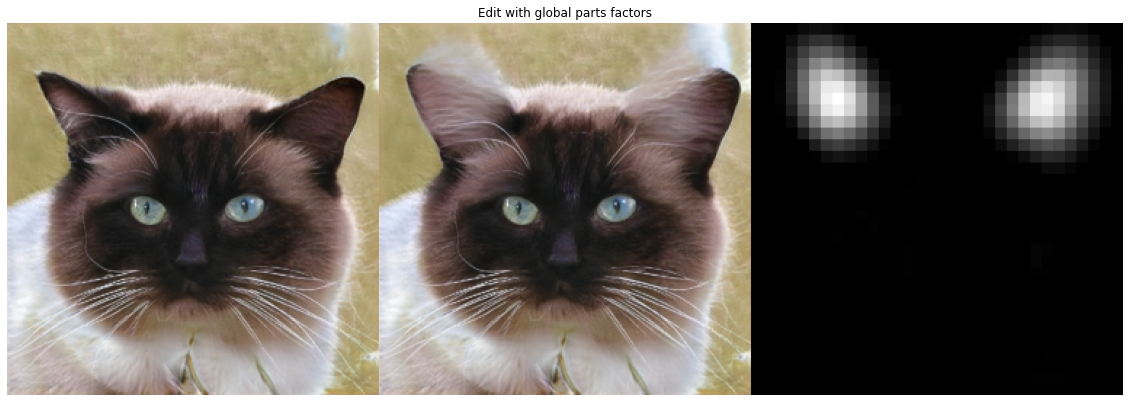

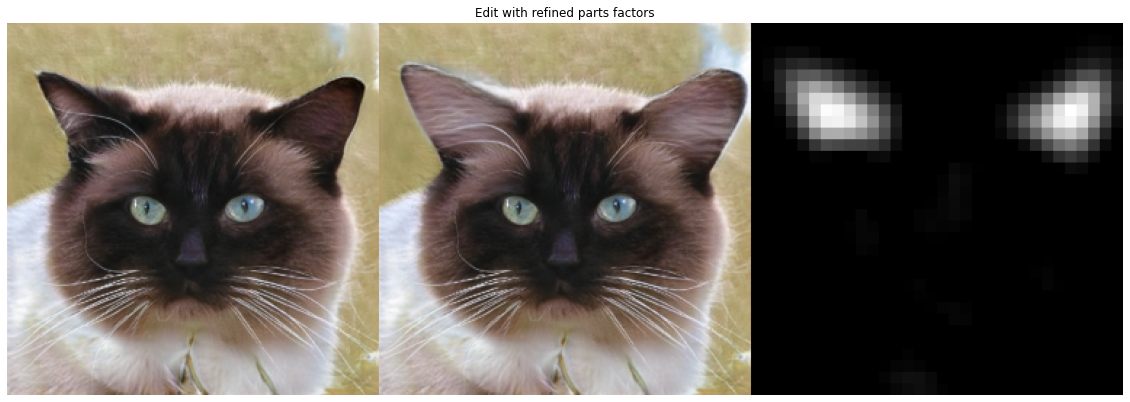

In [9]:
part = [[1, 8]]
appearance = [2]
lam = [50]

# edit using GLOBAL factors M.Us
Z, image, image2, part_img = M.edit_at_layer(part, appearance, lam, t, M.Uc, M.Us)

plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(np.concatenate([image, image2, part_img], 1))
plt.title('Edit with global parts factors')
plt.show()

# edit using REFINED factors UsR
Z, image, image2, part_img = M.edit_at_layer(part, appearance, lam, t, M.Uc, UsR)

plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(np.concatenate([image, image2, part_img], 1))
plt.title('Edit with refined parts factors')
plt.show()